In [113]:
import torch
import matplotlib.pyplot as plt

In [114]:
DATASET_PATH = '/home/kuba/projects/puff/test/data/trainhh.pt'

In [115]:
X, y = torch.load(DATASET_PATH)

In [116]:
print(f"\nX shape:{X.shape} y shape:{y.shape}")



X shape:torch.Size([22322, 3, 1024]) y shape:torch.Size([22322, 1024])


Window count with NO puffs: 21,287
Window count with at least one puff: 1,035


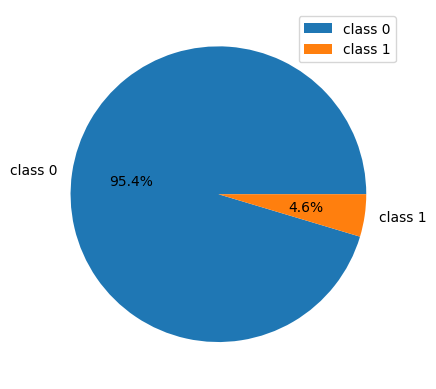

In [117]:
#CHECK the class distribution of y
CLASS = 1
class1_count = torch.sum((torch.count_nonzero(torch.isin(y, torch.tensor([CLASS])), dim=1) > 0))
class0_count = y.shape[0] - class1_count

print(f"Window count with NO puffs: {class0_count:,}\nWindow count with at least one puff: {class1_count:,}")
plt.pie([class0_count, class1_count],autopct='%1.1f%%', labels=['class 0', 'class 1']);
plt.legend()
plt.show()

In [118]:
#CHECK count the number of puffs

#note we an get:

"""
Original timeline: [0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]
                        ^label starts here

Window 1 (0-7):    [0,0,0,1,1,1,1,1] ← sees label start 
Window 2 (4-11):       [1,1,1,1,1,1,0,0] ← starts mid-label
Window 3 (8-15):           [1,1,0,0,0,0,0,0] ← starts mid-label



or another case:

Original timeline: [0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0]
                      ^-- puff 1 --^     ^-puff 2-^

Window 1 (0-7):    [0,0,1,1,1,1,1,1] ← sees start of puff 1 
Window 2 (4-11):      [1,1,1,1,1,1,0,0] ← NO new start (mid-puff 1)
Window 3 (8-15):        [1,1,0,0,0,1,1,1] ← sees start of puff 2 
Window 4 (12-19):          [0,1,1,1,1,0,0,0] ← sees FAKE start! 

ALL THESE ARTIFACTS FROM WINDOWING STOP BEEING AN ISSUE IF WE do step size = WINDOW SIZE

"""
diff = torch.diff(y, dim=1)

starts = (diff > 0).sum()
ends = (diff < 0).sum()
puffs_estim = (starts + ends) / 2
    
print(f'There are ~{puffs_estim:,} puffs in the dataset')

There are ~2,120.0 puffs in the dataset


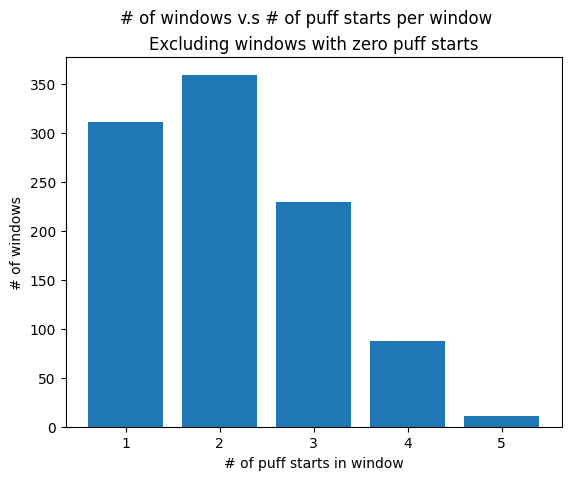

In [119]:
diff = torch.diff(y, dim=1)

starts_per_row = (diff > 0).sum(dim=1)
    
counts = {}

for row_estim in starts_per_row:
    counts[row_estim.item()] = counts.get(row_estim.item(),0) + 1

counts_list_with_zero = list(counts.values())
keys =  list(counts.keys())
counts_list_with_zero.remove(counts.get(0))
keys.remove(0)
plt.bar(keys, counts_list_with_zero)
plt.suptitle('# of windows v.s # of puff starts per window')
plt.title('Excluding windows with zero puff starts')
plt.xlabel('# of puff starts in window')
plt.ylabel('# of windows')
plt.show()

In [120]:
#CHECK the number of widows where that is and edge puff so at the start or end
diff = torch.diff(y, dim=1)

starts_per_row = (diff > 0).sum(dim=1)
ends_per_row = (diff < 0).sum(dim=1)
num_windows_with_end_puff = ((starts_per_row - ends_per_row) > 0).sum()
num_windows_with_start_puff = ((ends_per_row - starts_per_row) > 0).sum()

num_windows_with_puff_on_edge = (num_windows_with_start_puff + num_windows_with_end_puff)
print(f'There are {num_windows_with_puff_on_edge} with a puff on edge out of {class1_count} windows with a puff; {(num_windows_with_puff_on_edge/class1_count) * 100:.2f}%')

There are 500 with a puff on edge out of 1035 windows with a puff; 48.31%
